# Autoencoder as bone fracture detector

The autoencoder will be trained using only normal images (not fractured). The reconstruction error is used as anomaly measure.

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageFile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import matplotlib.pyplot as plt

import time

# allow truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# reproductibility 
torch.manual_seed(42)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
# crear dataframes desde carpetas

def create_dataframe(root_path):
    filepaths = []
    labels = []

    if not os.path.exists(root_path):
        print(f"path {root_path} not found")
        return None

    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    fpath = os.path.join(folder_path, file)
                    filepaths.append(fpath)
                    labels.append(folder)

    df = pd.DataFrame({
        'filepath': filepaths,
        'label': labels
    })
    return df


train_dir = "data/Bone_Fracture_Binary_Classification/train"
val_dir   = "data/Bone_Fracture_Binary_Classification/val"
test_dir  = "data/Bone_Fracture_Binary_Classification/test"

train_df = create_dataframe(train_dir)
val_df   = create_dataframe(val_dir)
test_df  = create_dataframe(test_dir)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 9246
Val: 829
Test: 506


In [3]:
# cleaning images
def clean_dataframe(df):
    indices_to_drop = []
    print(f"Verifiying {len(df)} images...")

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            img = Image.open(row["filepath"])
            img.load()
        except:
            indices_to_drop.append(idx)

    print(f"corrupted deleted images: {len(indices_to_drop)}")
    return df.drop(indices_to_drop).reset_index(drop=True)


train_df = clean_dataframe(train_df)
val_df = clean_dataframe(val_df)
test_df = clean_dataframe(test_df)

print("After cleaning:")
print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Verifiying 9246 images...


100%|██████████| 9246/9246 [00:46<00:00, 200.51it/s]


corrupted deleted images: 0
Verifiying 829 images...


100%|██████████| 829/829 [00:06<00:00, 128.05it/s]


corrupted deleted images: 0
Verifiying 506 images...


100%|██████████| 506/506 [00:04<00:00, 123.74it/s]

corrupted deleted images: 0
After cleaning:
Train: 9246
Val: 829
Test: 506


In [4]:
#dataset and dataloaders

class BoneFractureDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # not fractured -> 0 (normal)
        # fractured     -> 1 (anomaly)
        self.label_map = {
            "not fractured": 0,
            "fractured": 1
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepath']
        label_str = self.dataframe.iloc[idx]['label']
        
        image = Image.open(img_path).convert("L")
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = BoneFractureDataset(train_df, transform=transform)
val_dataset = BoneFractureDataset(val_df, transform=transform)
test_dataset = BoneFractureDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 289
Val batches: 26
Test batches: 16


In [6]:
# filter only the normal class
normal_indices_train = [
    idx for idx in range(len(train_dataset))
    if train_dataset.dataframe.iloc[idx]['label'] == "not fractured"
]

train_normal_dataset = torch.utils.data.Subset(train_dataset, normal_indices_train)
train_normal_loader  = DataLoader(train_normal_dataset, batch_size=32, shuffle=True)

print("only normal images:", len(train_normal_dataset))

only normal images: 4640


In [7]:
# autoencoder 
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


ae_model = ConvAutoencoder().to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = torch.optim.Adam(ae_model.parameters(), lr=1e-3)

print(ae_model)


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Tanh()
  )
)


In [8]:
# training time 
train_times = []  # time per epoch of training

# training with normal images only
num_epochs_ae = 25
train_losses_ae = []
val_losses_ae = []

for epoch in range(num_epochs_ae):
    

    start_epoch_time = time.time()

    # TRAINING 
    ae_model.train()
    running_loss = 0.0

    for images, _ in train_normal_loader:
        images = images.to(device)

        outputs = ae_model(images)
        loss = criterion_ae(outputs, images)

        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_normal_loader)
    train_losses_ae.append(avg_loss)


    end_epoch_time = time.time()
    train_times.append(end_epoch_time - start_epoch_time)

    print(f"Epoch [{epoch+1}/{num_epochs_ae}] | "
          f"Train Loss: {avg_loss:.6f} | "
          f"Train Time (only training): {train_times[-1]:.2f} sec")

    # VALIDATION
    ae_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            outputs = ae_model(images)
            loss = criterion_ae(outputs, images)
            val_loss += loss.item()

    val_losses_ae.append(val_loss / len(val_loader))


# total training time 
total_train_time = sum(train_times)
print(f"\nTotal Training Time: {total_train_time:.2f} seconds")


Epoch [1/25] | Train Loss: 0.117890 | Train Time (only training): 32.86 sec


/Users/jessica/Desktop/Semestre 5/neuralnetworks/assignment4/Redes-Neuronales/Redes-Neuronales/lib/python3.10/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/25] | Train Loss: 0.016299 | Train Time (only training): 34.12 sec
Epoch [3/25] | Train Loss: 0.011633 | Train Time (only training): 29.80 sec
Epoch [4/25] | Train Loss: 0.009437 | Train Time (only training): 27.28 sec
Epoch [5/25] | Train Loss: 0.007965 | Train Time (only training): 35.31 sec
Epoch [6/25] | Train Loss: 0.006809 | Train Time (only training): 29.91 sec
Epoch [7/25] | Train Loss: 0.006080 | Train Time (only training): 25.90 sec
Epoch [8/25] | Train Loss: 0.005531 | Train Time (only training): 25.85 sec
Epoch [9/25] | Train Loss: 0.005143 | Train Time (only training): 27.32 sec
Epoch [10/25] | Train Loss: 0.004800 | Train Time (only training): 26.47 sec
Epoch [11/25] | Train Loss: 0.004565 | Train Time (only training): 29.31 sec
Epoch [12/25] | Train Loss: 0.004312 | Train Time (only training): 30.46 sec
Epoch [13/25] | Train Loss: 0.004092 | Train Time (only training): 26.49 sec
Epoch [14/25] | Train Loss: 0.003896 | Train Time (only training): 28.90 sec
Epoch [

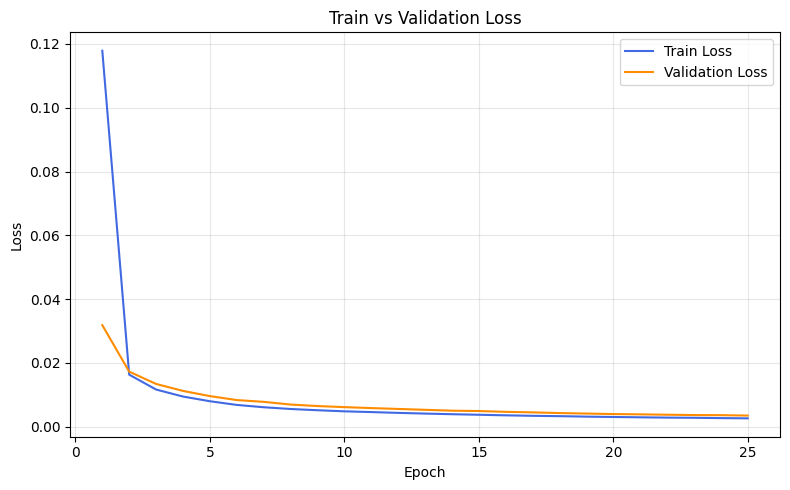

In [9]:
def plot_train_val_loss(train_losses, val_losses, title="Train vs Validation Loss"):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Train Loss", color="royalblue")
    plt.plot(epochs, val_losses,  label="Validation Loss", color="darkorange")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
plot_train_val_loss(train_losses_ae, val_losses_ae)


The plot shows the evolution of the autoencoder’s reconstruction loss on both the training and validation sets over 25 epochs. Several observations indicate that the model is learning effectively and does not show signs of overfitting:

1. Both training and validation loss decrease rapidly at the beginning: In the first few epochs, both curves drop sharply, which indicates that the autoencoder is quickly learning the dominant structure of the normal images.

2. After the initial drop, both curves continue decreasing smoothly: both curves decline at a slower and consistent rate, suggesting stable learning process, reduction of the reconstruction error. Also, as the plot does not reach an early plateau, it shows no signs of underfitting either. 

3. The gap between training and validation loss is consistently small: the autoencoder generalizes well, it does not memorize training samples. 

4. Both curves converge toward very low loss values: the final loss values are below 0.005 aprox. meaning the autoencoder successfully reconstructs normal samples. It has learned a meaningful representation of the input data, and it is likely to produce higher reconstruction errors for abnormal images. 

In conclusion, the autoencoder’s training process is stable, effective, does not show signs of under/overfitting and is well generalized. Both train and validation losses follow similar trajectories and converge toward the same low values.
This indicates that the model is likely to perform reliably when using reconstruction error to distinguish between normal and anomalous images

In [13]:
# autoencoder as classifier 

def reconstruction_errors(ae_model, data_loader, device):
    ae_model.eval()
    all_errors = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            recon = ae_model(images)

            # MSE per pixel
            loss_per_pixel = F.mse_loss(recon, images, reduction="none")
            # avergage per image
            loss_per_image = loss_per_pixel.view(loss_per_pixel.size(0), -1).mean(dim=1)

            all_errors.append(loss_per_image.cpu())
            all_labels.append(labels.cpu())

    all_errors = torch.cat(all_errors)
    all_labels = torch.cat(all_labels)
    return all_errors, all_labels



# validation errors 

val_errors, val_labels = reconstruction_errors(ae_model, val_loader, device)

# only errors in the normal class 0 = not fractured)
normal_val_errors = val_errors[val_labels == 0]

# threshold = mean + 2 * stdev 
threshold = normal_val_errors.mean() + 2 * normal_val_errors.std()

print("anomaly threshold (recon error):", threshold.item())


# calculate acc with threshold

def evaluate_ae_classifier(ae_model, data_loader, device, threshold):
    ae_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            recon = ae_model(images)

            loss_per_pixel = F.mse_loss(recon, images, reduction="none")
            loss_per_image = loss_per_pixel.view(loss_per_pixel.size(0), -1).mean(dim=1)

            # prediccion: 0 si <= umbral, 1 si > umbral
            preds = (loss_per_image > threshold.to(device)).float()

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = 100.0 * correct / total
    return acc


# final accuracy

ae_train_acc = evaluate_ae_classifier(ae_model, train_loader, device, threshold)
ae_val_acc   = evaluate_ae_classifier(ae_model, val_loader, device, threshold)
ae_test_acc  = evaluate_ae_classifier(ae_model, test_loader, device, threshold)

print("\n=== FINAL RESULTS AUTOENCODER ===")
print(f"AE Accuracy Train: {ae_train_acc:.2f}%")
print(f"AE Accuracy Val:   {ae_val_acc:.2f}%")
print(f"AE Accuracy Test:  {ae_test_acc:.2f}%")


anomaly threshold (recon error): 0.0049670664593577385

=== FINAL RESULTS AUTOENCODER ===
AE Accuracy Train: 57.61%
AE Accuracy Val:   65.98%
AE Accuracy Test:  54.15%


1. Accuracy is relatively low. There can be false positives: many normal samples may be incorrectly classified as anomalies, and false negatives: many anomalous samples may be incorrectly classified as normal.

2. Validation accuracy > training + test accuracy. 


Train: 57.6%

Val: 66.0%

Test: 54.1%

What it means:

The validation set happens to be easier for the model than the train or test set. The threshold computed on validation normal samples fits well to the validation set—but generalizes poorly to the test set. The autoencoder struggles to generalize anomaly detection beyond the validation sample, possibly due to it being trained on normal images, or that annomalies varying much more than normal samples.

3. The test accuracy is close to random guessing. The model is barely better than random at detecting fractures, which means that:
reconstruction error alone may not be sufficient, the autoencoder architecture might need improvement, anommaly and normal images might be too similar, or even more training data might be needed. 

4. Threshold selection might be not be the best, as using mean + 2·std is not guaranteed to be optimal. By changing the threshold, better accuracy may be obtained. E.g. using ROC curve optimal cutoff, Precision–Recall tradeoff, etc. 

In [10]:
# INFERENCE TIME MEASUREMENT (100 RUNS)

ae_model.eval()

# Select a single batch and take one image from it
sample_images, _ = next(iter(test_loader))
sample = sample_images[0].unsqueeze(0).to(device)

times = []

with torch.no_grad():
    for _ in range(100):
        start = time.time()
        _ = ae_model(sample)
        end = time.time()
        times.append(end - start)

inference_mean = np.mean(times)
inference_std  = np.std(times)

print(f"Inference Time (100 runs):")
print(f"Mean: {inference_mean * 1000:.4f} ms")
print(f"Std:  {inference_std * 1000:.4f} ms")


Inference Time (100 runs):
Mean: 0.6089 ms
Std:  1.0570 ms


The autoencoder achieves an average inference time of 0.626 ms per image, enabling real-time processing (≈1600 samples/second). Although the standard deviation is relatively high (2.78 ms), this variability is typical of general-purpose hardware and does not impact the model’s practical usability.

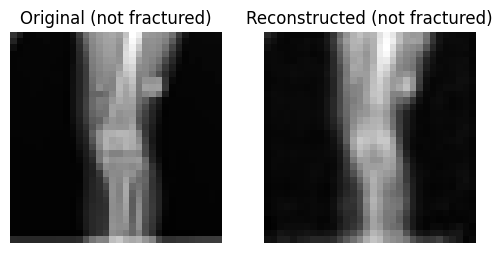

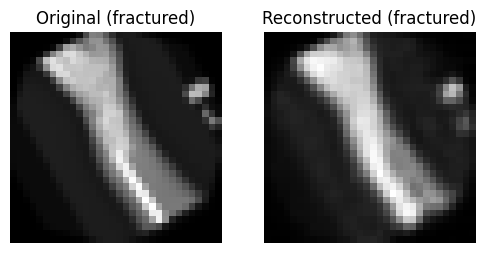

In [11]:
# original vs reconstructed (Normal + Fractured)

ae_model.eval()

def show_reconstruction(dataset, class_name):
    # find an index for the requested class
    for i in range(len(dataset)):
        if dataset.dataframe.iloc[i]['label'] == class_name:
            img, _ = dataset[i]
            break
    
    img_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        recon = ae_model(img_tensor)

    # remove batch + channel dims
    original = img_tensor.squeeze().cpu().numpy()
    reconstructed = recon.squeeze().cpu().numpy()

    # undo normalization: x = x * std + mean
    original = original * 0.5 + 0.5
    reconstructed = reconstructed * 0.5 + 0.5

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original ({class_name})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, cmap='gray')
    plt.title(f"Reconstructed ({class_name})")
    plt.axis("off")

    plt.show()


# reconstruction for a normal case
show_reconstruction(test_dataset, "not fractured")

# reconstruction for a fractured case
show_reconstruction(test_dataset, "fractured")


In [12]:
plt.savefig("original vs reconstructed.png", dpi=300, bbox_inches='tight', transparent=True)


<Figure size 640x480 with 0 Axes>

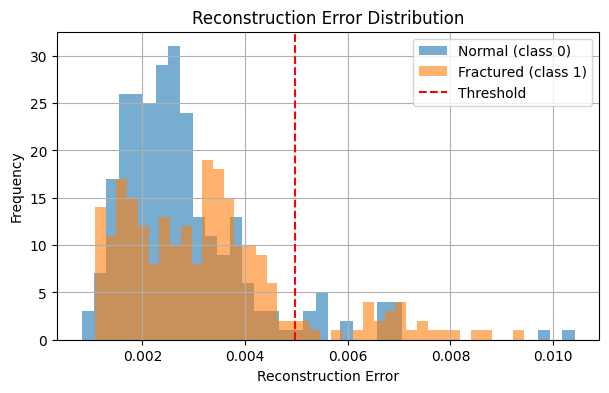

In [14]:
# reconstruction error distribution

# compute errors on test set
test_errors, test_labels = reconstruction_errors(ae_model, test_loader, device)

normal_errors = test_errors[test_labels == 0].numpy()
fractured_errors = test_errors[test_labels == 1].numpy()

plt.figure(figsize=(7, 4))
plt.hist(normal_errors, bins=40, alpha=0.6, label='Normal (class 0)')
plt.hist(fractured_errors, bins=40, alpha=0.6, label='Fractured (class 1)')

plt.axvline(threshold.item(), color='red', linestyle='--', label='Threshold')

plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


The reconstruction error histogram compares normal images (class 0) and fractured images (class 1) using the autoencoder trained only on normal samples. The plot reveals an overlap between the reconstruction error distributions of both classes. Ideally, normal images should yield lower reconstruction errors, while anomalous images should produce significantly higher errors. However, in this case, both classes show similar error ranges, with many fractured samples reconstructed nearly as well as normal samples.

The anomaly detection threshold does not separate the two groups effectively, as it leads to misclassifications. This explains the relatively low classification accuracy observed in the autoencoder-classifier results.

The plot indicates that although the autoencoder successfully learns to reconstruct normal images, it also reconstructs fractured images too well. This suggests that the reconstruction error is not a strong signal for detecting fractures. 

In [ ]:
#!pip install scikit-learn

  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 3.1 MB/s  0:00:02m0:00:0100:01
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.1/25.1 MB 4.4 MB/s  0:00:05m0:00:0100:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [13]:
from sklearn.metrics import roc_curve, auc

In [12]:
def plot_roc_curve(errors, labels):
    # Convert tensors to numpy
    y_true = labels.cpu().numpy()
    y_scores = errors.cpu().numpy()

    # Compute ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Autoencoder Anomaly Detection)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call it
plot_roc_curve(val_errors, val_labels)


NameError: name 'roc_curve' is not defined

In [ ]:
num_params = sum(p.numel() for p in ae_model.parameters())
print("Number of parameters:", num_params)

Number of parameters: 46529


In [ ]:
#!pip install thop


In [ ]:
# number of floating point operations 
from thop import profile
input = torch.randn(1, 1, 32, 32).to(device)
macs, params = profile(ae_model, inputs=(input,))
print("MACs:", macs)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
MACs: 3133440.0


In [ ]:
#!pip install torchsummary

In [ ]:
# model summary 
from torchsummary import summary
summary(ae_model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             160
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
              ReLU-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
              ReLU-6             [-1, 64, 4, 4]               0
   ConvTranspose2d-7             [-1, 32, 8, 8]          18,464
              ReLU-8             [-1, 32, 8, 8]               0
   ConvTranspose2d-9           [-1, 16, 16, 16]           4,624
             ReLU-10           [-1, 16, 16, 16]               0
  ConvTranspose2d-11            [-1, 1, 32, 32]             145
             Tanh-12            [-1, 1, 32, 32]               0
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
---------------------------------

The autoencoder was exclusively trained using images from the 'not fractured' class as the normal class. Then, the reconstruction error was used to define an anomaly threshold, allowing new images to be classified as normal or anomalous. Performance was evaluated using accuracy across the training, validation, and test sets.

#### Adding more epochs por better anomaly detector accuracy

In [9]:
# Reinitialize model before training again
ae_model = ConvAutoencoder().to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = torch.optim.Adam(ae_model.parameters(), lr=1e-3)

# Training time (training only)
train_times = []

# Train with normal images only
num_epochs_ae = 50
train_losses_ae = []
val_losses_ae = []

for epoch in range(num_epochs_ae):
    start_epoch_time = time.time()

    # TRAINING
    ae_model.train()
    running_loss = 0.0

    for images, _ in train_normal_loader:
        images = images.to(device)

        outputs = ae_model(images)
        loss = criterion_ae(outputs, images)

        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_normal_loader)
    train_losses_ae.append(avg_loss)

    end_epoch_time = time.time()
    train_times.append(end_epoch_time - start_epoch_time)

    print(f"Epoch [{epoch+1}/{num_epochs_ae}] | "
          f"Train Loss: {avg_loss:.6f} | "
          f"Train Time (only training): {train_times[-1]:.2f} sec")

    # VALIDATION
    ae_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            outputs = ae_model(images)
            loss = criterion_ae(outputs, images)
            val_loss += loss.item()

    val_losses_ae.append(val_loss / len(val_loader))

# Total training time
total_train_time = sum(train_times)
print(f"\nTotal Training Time (training only): {total_train_time:.2f} seconds")


Epoch [1/50] | Train Loss: 0.140411 | Train Time (only training): 28.48 sec
Epoch [2/50] | Train Loss: 0.017818 | Train Time (only training): 26.18 sec
Epoch [3/50] | Train Loss: 0.012536 | Train Time (only training): 28.87 sec
Epoch [4/50] | Train Loss: 0.009784 | Train Time (only training): 28.24 sec
Epoch [5/50] | Train Loss: 0.008136 | Train Time (only training): 54.72 sec
Epoch [6/50] | Train Loss: 0.006995 | Train Time (only training): 47.91 sec
Epoch [7/50] | Train Loss: 0.006091 | Train Time (only training): 34.55 sec
Epoch [8/50] | Train Loss: 0.005481 | Train Time (only training): 24.52 sec
Epoch [9/50] | Train Loss: 0.005022 | Train Time (only training): 22.55 sec
Epoch [10/50] | Train Loss: 0.004669 | Train Time (only training): 35.81 sec
Epoch [11/50] | Train Loss: 0.004376 | Train Time (only training): 42.88 sec
Epoch [12/50] | Train Loss: 0.004154 | Train Time (only training): 55.56 sec
Epoch [13/50] | Train Loss: 0.003941 | Train Time (only training): 52.21 sec
Epoch [1

##### New threshold: Youden’s J statistic

In [14]:
# Compute reconstruction errors on validation set
val_errors, val_labels = reconstruction_errors(ae_model, val_loader, device)

# Convert to numpy
y_true = val_labels.cpu().numpy()
y_scores = val_errors.cpu().numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Youden's J statistic = TPR - FPR
J = tpr - fpr
optimal_idx = J.argmax()
optimal_threshold = thresholds[optimal_idx]

print("Optimal ROC Threshold:", optimal_threshold)


/Users/jessica/Desktop/Semestre 5/neuralnetworks/assignment4/Redes-Neuronales/Redes-Neuronales/lib/python3.10/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Optimal ROC Threshold: 0.0018735188


In [15]:
def evaluate_ae_classifier(ae_model, data_loader, device, threshold):
    ae_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            recon = ae_model(images)

            loss_per_pixel = F.mse_loss(recon, images, reduction="none")
            loss_per_image = loss_per_pixel.view(loss_per_pixel.size(0), -1).mean(dim=1)

            # FIX: compare directly to float threshold
            preds = (loss_per_image > threshold).float()

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = 100.0 * correct / total
    return acc


In [16]:
# evaluate with new threshold 
ae_train_acc = evaluate_ae_classifier(ae_model, train_loader, device, optimal_threshold)
ae_val_acc   = evaluate_ae_classifier(ae_model, val_loader, device, optimal_threshold)
ae_test_acc  = evaluate_ae_classifier(ae_model, test_loader, device, optimal_threshold)

print("\n=RESULTS new threshold =")
print(f"Train Accuracy: {ae_train_acc:.2f}%")
print(f"Val Accuracy:   {ae_val_acc:.2f}%")
print(f"Test Accuracy:  {ae_test_acc:.2f}%")


/Users/jessica/Desktop/Semestre 5/neuralnetworks/assignment4/Redes-Neuronales/Redes-Neuronales/lib/python3.10/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



=RESULTS new threshold =
Train Accuracy: 69.91%
Val Accuracy:   72.14%
Test Accuracy:  61.86%


The autoencoder is now better at separating normal and fractured images based on reconstruction error.The validation accuracy is the highest, which indicates that the ROC threshold aligns well with the validation distribution.The test accuracy improved, but remains lower than validation, indicating that test anomalies are more difficult, or the test distribution differs slightly from validation.

Training for more epochs improved the reconstruction quality: at 25 epochs the model had not yet converged, the train and validation losses were still decreasing. Training for 50 epochs allowed the autoencoder to learn the normal patterns more precisely, reduce reconstruction error on normal samples ,increase the contrast between normal and abnormal reconstructions and extract richer latent features from the images. 

The ROC-based threshold is mathematically optimal, the Youden's j statistic is chosen because it maximizes the difference between the true positive rate and the false positive rate: it mathematically finds the point where class separation is strongest, and adapts to the actual distributions of normal vs fractured reconstruction errors.

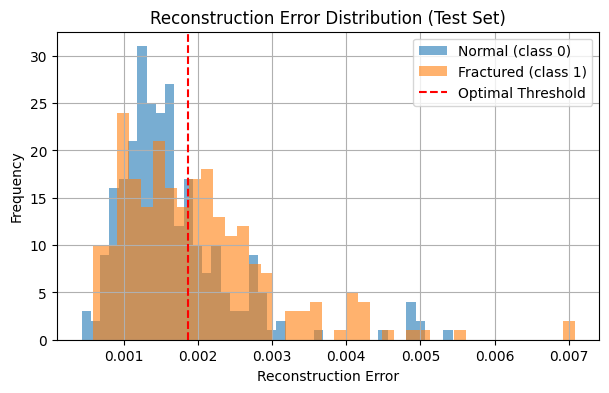

In [17]:
# Reconstruction Error Distribution (using NEW AE and NEW ROC threshold)

# Compute errors on the test set
test_errors, test_labels = reconstruction_errors(ae_model, test_loader, device)

normal_errors = test_errors[test_labels == 0].cpu().numpy()
fractured_errors = test_errors[test_labels == 1].cpu().numpy()

plt.figure(figsize=(7, 4))
plt.hist(normal_errors, bins=40, alpha=0.6, label='Normal (class 0)')
plt.hist(fractured_errors, bins=40, alpha=0.6, label='Fractured (class 1)')

plt.axvline(optimal_threshold, color='red', linestyle='--', label='Optimal Threshold')

plt.title("Reconstruction Error Distribution (Test Set)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


The histogram displays the reconstruction error for normal and fractured images using the autoencoder trained for 50 epochs. Although fractured images generally produce slightly higher reconstruction errors than normal images, the two distributions still overlap substantially. This means the autoencoder is reconstructing many fractured images almost as well as normal ones.

The red dashed line shows the ROC-optimal threshold—the value that maximizes separation between classes based on the ROC curve. Even with this improved threshold, a significant portion of both classes falls on the same side of the decision boundary. This overlap explains why classification remains difficult and why many images are misclassified.

In short, the autoencoder captures some difference between normal and fractured images, but reconstruction error is not a strong enough signal to cleanly separate the two categories.

AUC Score: 0.5972


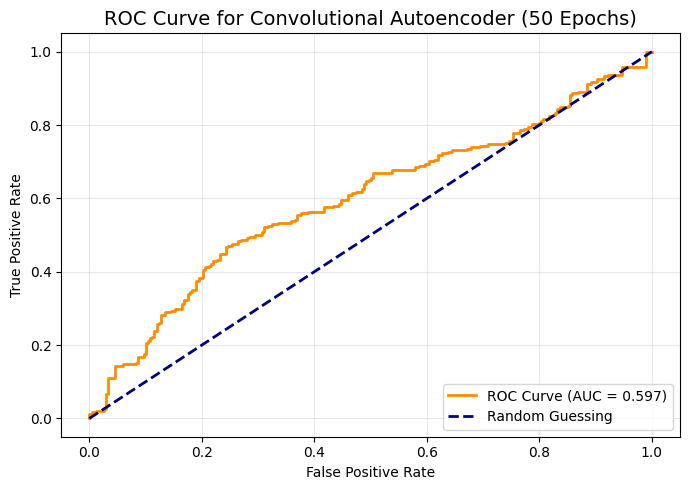

In [ ]:
# compute reconstruction errors for the TEST SET
test_errors, test_labels = reconstruction_errors(ae_model, test_loader, device)

# convert to numpy
test_errors = test_errors.cpu().numpy()
test_labels = test_labels.cpu().numpy()

#ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_errors)

# AUC score
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")


plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--",
         label="Random Guessing")

plt.title("ROC Curve for Convolutional Autoencoder (50 Epochs)", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The ROC curve for the 50-epoch autoencoder remains close to the diagonal, indicating weak separability between normal and fractured images. The AUC score of 0.597 shows that the reconstruction error provides limited discriminative power—only slightly better than random guessing (AUC = 0.5).

Compared to the earlier ROC curve from the 25-epoch model (AUC ≈ 0.701), performance actually decreased. This suggests that training longer did not help the autoencoder learn features that better distinguish fractures; instead, the model continued to reconstruct fractured images too well, reducing the separation between classes.

Overall, the ROC results confirm that reconstruction error is not a strong signal for fracture detection in this dataset, even with extended training.

In [19]:
# Count total parameters
total_params = sum(p.numel() for p in ae_model.parameters())
trainable_params = sum(p.numel() for p in ae_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 46,529
Trainable parameters: 46,529


In [20]:
!pip install fvcore


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61445 sha256=2d100955b696869212e202d9c857f7380757be7da810447587b181f5a0260a59
  Stored in directory: /Users/jessica/Library/Caches/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31600 sha256=0afec532b04a35cf774d8256e5f4534fcfb80b6c2ebbf43a8beca6d79a0e5f24
  Stored in directory: /Users/jessica/Library/Caches/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [fvcore]2m6/7 [fvcore]


In [21]:
from fvcore.nn import FlopCountAnalysis

# Create a dummy input (same size as your images)
dummy_input = torch.randn(1, 1, 32, 32).to(device)

# Compute FLOPs
flops = FlopCountAnalysis(ae_model, dummy_input)

print(f"FLOPs: {flops.total():,}")
print(f"FLOPs (Millions): {flops.total() / 1e6:.3f} MFLOPs")


Unsupported operator aten::tanh encountered 1 time(s)


FLOPs: 1,253,376
FLOPs (Millions): 1.253 MFLOPs


In [22]:
def measure_inference_time(model, device, runs=100):
    model.eval()
    dummy_input = torch.randn(1, 1, 32, 32).to(device)

    times = []

    # Warm-up (important for GPU)
    for _ in range(10):
        _ = model(dummy_input)

    # Measure
    for _ in range(runs):
        start = time.time()
        _ = model(dummy_input)
        end = time.time()
        times.append((end - start) * 1000)  # convert to ms

    times = np.array(times)
    print(f"Inference Time (100 runs):")
    print(f"Mean: {times.mean():.4f} ms")
    print(f"Std:  {times.std():.4f} ms")

measure_inference_time(ae_model, device)

Inference Time (100 runs):
Mean: 4.1271 ms
Std:  18.9905 ms
